In [1]:
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import scipy.stats as stats

In [2]:
# create dataset
n = 1000
omega = 0.5

alpha_1 = 0.1
alpha_2 = 0.2

beta_1 = 0.3
beta_2 = 0.4

test_size = int(n*0.1)

series = [gauss(0,1), gauss(0,1)]
vols = [1, 1]

for _ in range(n):
    new_vol = np.sqrt(omega + alpha_1*series[-1]**2 + alpha_2*series[-2]**2 + beta_1*vols[-1]**2 + beta_2*vols[-2]**2)
    new_val = gauss(0,1) * new_vol
    
    vols.append(new_vol)
    series.append(new_val)

In [3]:

svols=pd.Series(vols,index=range(n+2))

In [4]:
sseries=pd.Series(series,index=range(n+2))

In [5]:
df=pd.concat([svols,sseries],1)
df.columns=['vols','values']

<AxesSubplot:>

<Figure size 1000x600 with 0 Axes>

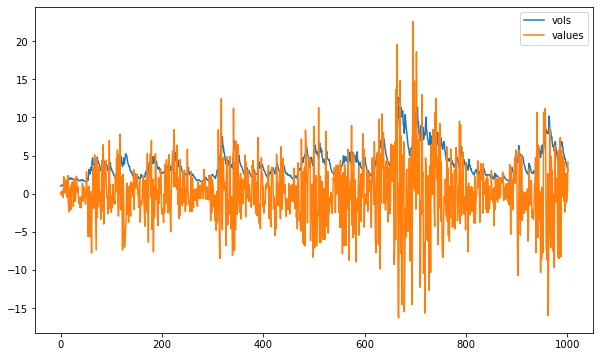

In [6]:
# plt.figure(figsize=(20,10))
plt.rcParams["figure.figsize"] = (10, 6)
plt.figure(dpi=100)
df.plot()


## GARCH model
### Step 1: check the serial correlation and volatility clustering
### step 2: determine the parameters in the Garch(p,q) model


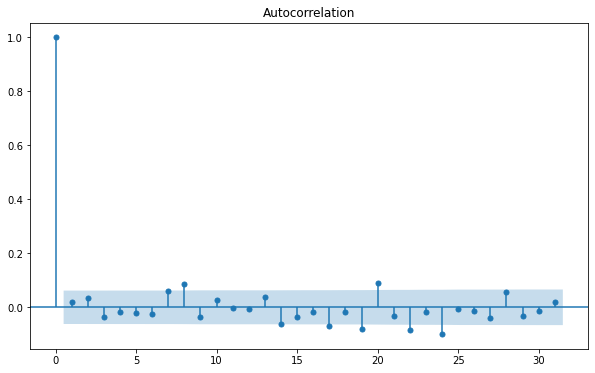

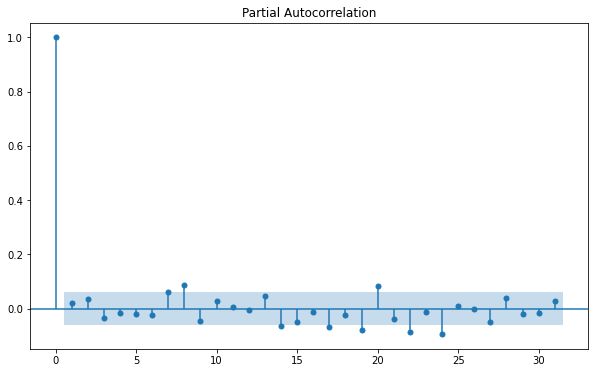

In [7]:
# serial correlation
acf=plot_acf(df['values'])
pacf=plot_pacf(df['values'])

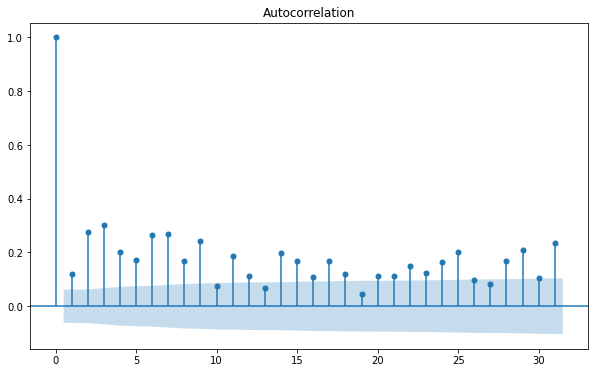

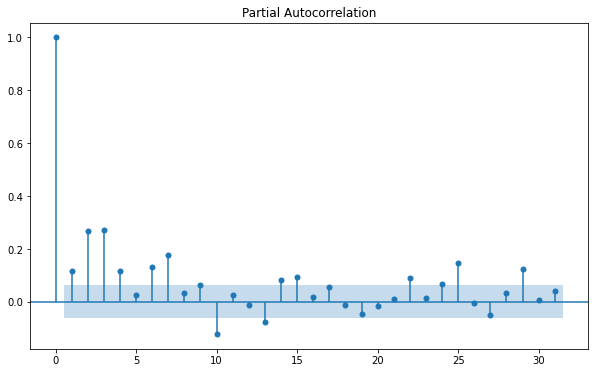

In [8]:
## volatilit clustering
# acf=plot_acf(df['values'].abs())
acf2=plot_acf(df['values']**2)
# pacf=plot_pacf(df['values'].abs())
pacf2=plot_pacf(df['values']**2)

### Step 3: fit the model with the data

In [9]:
model=arch_model(df['values'],p=2,q=2)
model_fit=model.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 41578.721133163184
Iteration:      2,   Func. Count:     17,   Neg. LLF: 155246.6463073002
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2919.2338933194815
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2664.9638502096072
Iteration:      5,   Func. Count:     41,   Neg. LLF: 2665.8380202076023
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2725.645075525358
Iteration:      7,   Func. Count:     58,   Neg. LLF: 2667.0393896052537
Iteration:      8,   Func. Count:     66,   Neg. LLF: 2664.529483998319
Iteration:      9,   Func. Count:     73,   Neg. LLF: 2664.5262557202423
Iteration:     10,   Func. Count:     80,   Neg. LLF: 2664.5251012289054
Iteration:     11,   Func. Count:     87,   Neg. LLF: 2664.5250557481154
Iteration:     12,   Func. Count:     94,   Neg. LLF: 2664.5250548859203
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2664.5250548859203
            Iterat

In [10]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 values   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -2664.53
Distribution:                  Normal   AIC:                           5341.05
Method:            Maximum Likelihood   BIC:                           5370.51
                                        No. Observations:                 1002
Date:                Mon, Jan 25 2021   Df Residuals:                      996
Time:                        22:31:51   Df Model:                            6
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1384  8.448e-02      1.639      0.101 [-2.714e-02,  0.304]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.2970      0.116      2.559  1.049e-02    [6.955e-02,  0.524]
alpha[1]       0.0129  3.319e-02      0.389      0.697 [-5.214e-02,7.796e-02]
alpha[2]       0.2287  4.713e-02      4.853  1.217e-06      [  0.136,  0.321]
beta[1]        0.6790      0.152      4.455  8.389e-06      [  0.380,  0.978]
beta[2]        0.0793      0.135      0.586      0.558      [ -0.186,  0.344]
=============================================================================

Covariance estimator: robust
"""

In [14]:
df['fitted_vol']=model_fit.conditional_volatility

<AxesSubplot:>

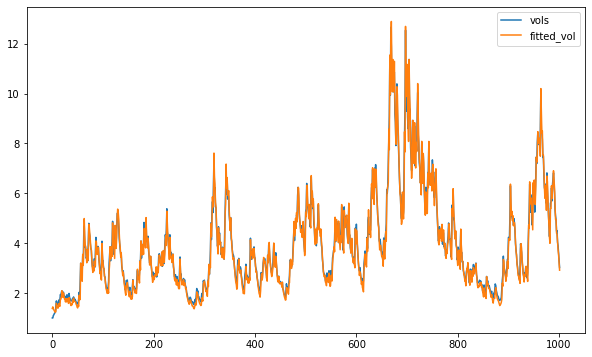

In [15]:
df[['vols','fitted_vol']].plot()

### forcast model

In [18]:
test_size=int(n*0.2)
# zz=stats.norm.ppf(0.05)
zz=model.distribution.ppf(0.05)
vols=[]
vars=[]
for i in range(test_size):
    train,test=df['values'][:-(test_size-i)],df['values'][-(test_size-i):]
    model=arch_model(train,p=2,q=2)
    model_fit=model.fit(disp='off')
    pvol=np.sqrt(model_fit.forecast(horizon=5).residual_variance.iloc[-1,0])
    pmu=model_fit.forecast(horizon=5).mean.iloc[-1,0]
    pvar=pmu+zz*pvol
    vols.append(pvol)
    vars.append(pvar)
    

pred_df=pd.DataFrame({'Vols':vols,"vars":vars},index=df.index[-test_size:])
final_df=pd.concat([df,pred_df],1)


0.06

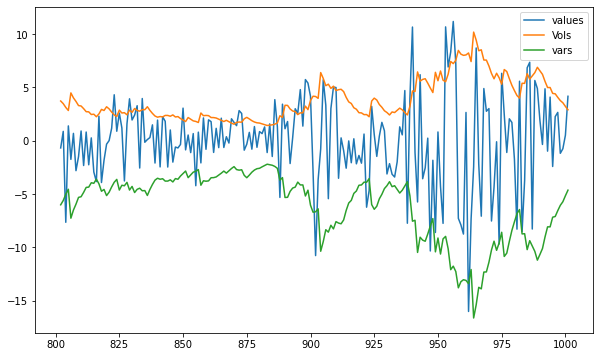

In [19]:
final_df[['values','Vols','vars']].loc[pred_df.index].plot()
suc=final_df['values'].loc[pred_df.index]<final_df['vars'].loc[pred_df.index]
suc.mean()


In [20]:
final_df.loc[df.index[-test_size:]]

,vols,values,predicted_vol,fitted_vol,Vols,vars
802,3.686663,-0.675467,3.724703,3.724703,3.723301,-6.007028
803,3.380002,0.875663,3.458223,3.458223,3.477834,-5.603724
804,3.087369,-7.646900,3.110795,3.110795,3.120509,-5.015704
805,3.732316,1.389803,2.953581,2.953581,2.834744,-4.550418
806,4.514418,-1.747721,4.568531,4.568531,4.484035,-7.261967
...,...,...,...,...,...,...
997,4.036902,2.655198,4.040234,4.040234,4.065326,-6.554199
998,3.901200,-1.179520,3.742346,3.742346,3.763431,-6.056203
999,3.624028,-0.749431,3.545874,3.545874,3.558030,-5.718278
1000,3.295791,0.518412,3.217655,3.217655,3.217692,-5.157981


In [21]:
test_size=int(n*0.2)
zz=stats.norm.ppf(0.05)
# Alternatively we use
# zz=model.distribution.ppf(0.05)
vols={}
vars={}
for i in range(test_size):
    train,test=df['values'][:-(test_size-i)],df['values'][-(test_size-i):]
    model=arch_model(train,p=2,q=2)
    model_fit=model.fit(disp='off')
    temp_1=model_fit.forecast(horizon=5).residual_variance.iloc[-1,:]
    vols[temp_1.name]=temp_1
    temp_2=model_fit.forecast(horizon=5).mean.iloc[-1,:]
    temp_3=temp_2+zz*np.sqrt(temp_1)
    vars[temp_3.name]=temp_3

    

In [22]:
vars=pd.DataFrame(vars).T
vols=pd.DataFrame(vols).T.apply(np.sqrt)



In [23]:
vars.head()

,h.1,h.2,h.3,h.4,h.5
801,-6.007028,-5.603975,-5.766927,-5.792732,-5.850159
802,-5.603724,-5.018544,-5.233546,-5.253999,-5.318821
803,-5.015704,-4.512229,-4.715225,-4.745709,-4.815326
804,-4.550418,-7.257382,-6.784510,-6.948837,-6.964061
805,-7.261967,-6.498062,-6.735854,-6.736517,-6.790520


In [24]:
vols.head()

,h.1,h.2,h.3,h.4,h.5
801,3.723301,3.478262,3.577330,3.593018,3.627931
802,3.477834,3.122070,3.252781,3.265216,3.304625
803,3.120509,2.814418,2.937830,2.956364,2.998687
804,2.834744,4.480461,4.192975,4.292879,4.302134
805,4.484035,4.019614,4.164181,4.164584,4.197416


In [25]:
forecasts = model_fit.forecast(horizon=5, start=801)

In [26]:
forecasts.residual_variance.dropna().apply(np.sqrt)

,h.1,h.2,h.3,h.4,h.5
801,3.722235,3.479794,3.597387,3.603716,3.643124
802,3.453534,3.128423,3.277103,3.278463,3.323415
803,3.103230,2.831908,2.968251,2.978041,3.024972
804,2.953381,4.580935,4.188450,4.346577,4.333641
805,4.570156,3.979238,4.204189,4.172893,4.218118
...,...,...,...,...,...
996,4.027455,3.747190,3.873724,3.874405,3.912658
997,3.728972,3.556151,3.651004,3.663434,3.700337
998,3.532454,3.227976,3.368582,3.371031,3.414426
999,3.202887,2.924420,3.061423,3.069461,3.115453
